This sample demonstrates celebrity face classification using Keras with transfer learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip /content/drive/My\ Drive/output.zip

Archive:  /content/drive/My Drive/output.zip
   creating: output/
   creating: output/train/
   creating: output/train/17BIT048/
  inflating: output/train/17BIT048/17BIT048_Male_Fear_RGB.png  
  inflating: output/train/17BIT048/17BIT048_Male_Disgust_RGB.png  
  inflating: output/train/17BIT048/17BIT048_Male_Surprise_Sketch.png  
  inflating: output/train/17BIT048/17BIT048_Male_Sad_RGB.png  
  inflating: output/train/17BIT048/17BIT048_Male_Anger_Sketch.png  
  inflating: output/train/17BIT048/17BIT048_Male_Fear_Sketch.png  
  inflating: output/train/17BIT048/17BIT048_Male_Anger_RGB.png  
  inflating: output/train/17BIT048/17BIT048_Male_Disgust_Sketch.png  
  inflating: output/train/17BIT048/17BIT048_Male_Happy_Sketch.png  
  inflating: output/train/17BIT048/17BIT048_Male_Surprise_RGB.png  
  inflating: output/train/17BIT048/17BIT048_Male_Happy_RGB.png  
   creating: output/train/17BIT011/
  inflating: output/train/17BIT011/17BIT011_Male_Happy_RGB.png  
  inflating: output/train/17BIT011

In [12]:
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d gaborfodor/keras-pretrained-models

100% 941M/943M [00:05<00:00, 165MB/s]
100% 943M/943M [00:05<00:00, 182MB/s]


In [13]:
!unzip keras-pretrained-models.zip

Archive:  keras-pretrained-models.zip
  inflating: Kuszma.JPG              
  inflating: imagenet_class_index.json  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("output"))
print(os.listdir("."))

data_dir = 'output'
vgg16weight = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50weight = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

['train', 'test', 'val']
['.config', 'Kuszma.JPG', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'keras-pretrained-models.zip', 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'drive', 'xception_weights_tf_dim_ordering_tf_kernels.h5', 'output', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json', 'sample_data']


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K

import keras

import matplotlib.pyplot as plt

### 1. Prepare Data

In [0]:
img_width, img_height = 200, 200

train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'test')
nb_train_samples = 330
nb_validation_samples = 62
epochs = 20
batch_size = 30
numclasses = 30

In [17]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 330 images belonging to 30 classes.
Found 62 images belonging to 30 classes.


### 2. Model

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
        
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model
 
def resnet50tl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(resnet50weight)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model


In [20]:
model = resnet50tl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### 3. Train

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
11/11 [==============================] - 52s 5s/step - loss: 5.1708 - accuracy: 0.0788 - val_loss: 3.4842 - val_accuracy: 0.0333
Epoch 2/20
11/11 [==============================] - 43s 4s/step - loss: 3.1496 - accuracy: 0.2636 - val_loss: 3.5320 - val_accuracy: 0.0312
Epoch 3/20
11/11 [==============================] - 39s 4s/step - loss: 2.3467 - accuracy: 0.4121 - val_loss: 3.6282 - val_accuracy: 0.0312
Epoch 4/20
11/11 [==============================] - 43s 4s/step - loss: 1.9254 - accuracy: 0.4545 - val_loss: 3.7046 - val_accuracy: 0.0500
Epoch 5/20
11/11 [==============================] - 44s 4s/step - loss: 1.5620 - accuracy: 0.5545 - val_loss: 4.1975 - val_accuracy: 0.0312
Epoch 6/20
11/11 [==============================] - 39s 4s/step - loss: 1.0605 - accuracy: 0.7121 - val_loss: 5.2261 - val_accuracy: 0.0312
Epoch 7/20
11/11 [==============================] - 42s 4s/step - loss: 0.8992 - accuracy: 0.7424 - val_loss: 4.8854 - val_accuracy: 0.0667
Epoch 8/20
11/11 [==

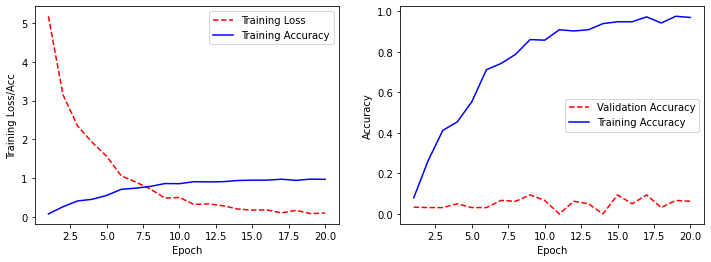

In [22]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [0]:
saveweight =  'face_weight.h5'
model.save_weights(saveweight)

### 4. Evaluation

In [0]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

Found 30 images belonging to 30 classes.
{'17BIT004': 0, '17BIT007': 1, '17BIT008': 2, '17BIT009': 3, '17BIT010': 4, '17BIT011': 5, '17BIT012': 6, '17BIT014': 7, '17BIT017': 8, '17BIT022': 9, '17BIT024': 10, '17BIT025': 11, '17BIT026': 12, '17BIT027': 13, '17BIT031': 14, '17BIT032': 15, '17BIT035': 16, '17BIT036': 17, '17BIT037': 18, '17BIT038': 19, '17BIT039': 20, '17BIT040': 21, '17BIT041': 22, '17BIT044': 23, '17BIT045': 24, '17BIT046': 25, '17BIT048': 26, '17BIT051': 27, '17BIT053': 28, '17BIT34': 29}


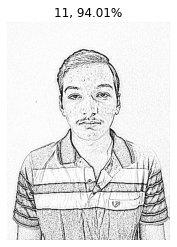

In [47]:
labels = ['3','4','7','8','9','10','11','12','14','17','22','24','25','26','27','31','32','35','36','37','38','39','40','41','44','45','46','48','51','53','34']
#lables = np.asarray(lables)
#lables.shape
test_imgs = ['/content/output/val/17BIT011/17BIT011_Male_Sad_Sketch.png']
generator= train_datagen.flow_from_directory("output/val", batch_size=batch_size)
label_map = (generator.class_indices)
print(label_map)

for test in test_imgs:
    test_img = os.path.join(validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)
    
    #print("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))